<a href="https://colab.research.google.com/github/AntonLissa/trajectory_prediction/blob/main/CV_3_Dataset_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd 'drive/MyDrive/CV_project'

Mounted at /content/drive/
/content/drive/MyDrive/CV_project


# Make the dataset and train the model
I worked with two different approaches:


*   Developing of a single "total model" for the prediction of any trajectory
*   Developing of 4 different "specialized" models: North, South, East and West; each one will predict the trajectory of a car that enters the intersection from the relative zone



In [ ]:
import pandas as pd

def load_df(name):
  total_df = pd.read_csv(name)
  total_df['X'] = total_df['X'].apply(eval)  # convert string to list
  total_df['Y'] = total_df['Y'].apply(eval)
  return total_df

total_df = load_df('Dataframes/total_df_300')
north_df = load_df('Dataframes/north_df_300')
south_df = load_df('Dataframes/south_df_300')
east_df = load_df('Dataframes/east_df_300')
west_df = load_df('Dataframes/west_df_300')

In [ ]:
# makes the dataset for the training and testing
# it splits the trajectories using a sliding window approach and then shuffles the dataset
# Inputs:
# - dataframe: a pandas DataFrame containing 'X' and 'Y' trajectories
# - input_length: the length of the input sequences
# - output_length: the length of the output sequences
# - step: the step size for the sliding window approach

import pandas as pd
import numpy as np
np.random.seed(1)

def create_dataset(dataframe, input_length, output_length, step):
    input_sequences = []
    output_sequences = []

    for index, row in dataframe.iterrows():
        x_trajectory = row['X']
        y_trajectory = row['Y']

        # Split the trajectory into sub-sequences with the specified step
        for i in range(0, len(x_trajectory) - input_length - output_length + 1, step):

            # Extract the input sub-trajectory
            input_seq_x = x_trajectory[i:i+input_length]
            input_seq_y = y_trajectory[i:i+input_length]
            input_sequence = np.column_stack((input_seq_x, input_seq_y))

            # Extract the output sub-trajectory
            output_seq_x = x_trajectory[i+input_length:i+input_length+output_length]
            output_seq_y = y_trajectory[i+input_length:i+input_length+output_length]
            output_sequence = np.column_stack((output_seq_x, output_seq_y))

            input_sequences.append(input_sequence)
            output_sequences.append(output_sequence)

    input_sequences = np.array(input_sequences)
    output_sequences = np.array(output_sequences)

    # shuffle
    random_indices = np.random.permutation(len(input_sequences))
    input_sequences = input_sequences[random_indices]
    output_sequences = output_sequences[random_indices]


    return np.array(input_sequences), np.array(output_sequences)



#input_sequences, output_sequences = create_dataset(df, input_length, output_length, step)
#print('numero righe:', len(input_sequences))

In [ ]:
# let's make the datasets

input_length = 10 # how many points in input
output_length = 50 # how many points to predict
step = 2 # step size for the sliding window

# for a single total model
input_sequences, output_sequences = create_dataset(total_df, input_length, output_length, step)

# for 4 different models, one for each zone
input_sequences_north, output_sequences_north = create_dataset(north_df, input_length, output_length, step)
input_sequences_south, output_sequences_south = create_dataset(south_df, input_length, output_length, step)
input_sequences_east, output_sequences_east = create_dataset(east_df, input_length, output_length, step)
input_sequences_west, output_sequences_west = create_dataset(west_df, input_length, output_length, step)
print(len(input_sequences))
print(len(input_sequences_north))

38400
9600


In [ ]:
# scales the data in a range [0, 1] according to the video dimensions

def scale(array, W, H):
    scaled_array = array.copy()
    scaled_array[:,:,0] /= W
    scaled_array[:,:,1] /= H
    return scaled_array

def descale(array, W, H):
    scaled_array = array.copy()
    scaled_array[:,:,0] *= W
    scaled_array[:,:,1] *= H
    return scaled_array

# W = video width
# H = video height
W = 1280
H = 680
input_scaled, output_scaled  = scale(input_sequences, W, H), scale(output_sequences, W, H)
north_input_scaled, north_output_scaled  = scale(input_sequences_north, W, H), scale(output_sequences_north, W, H)
south_input_scaled, south_output_scaled  = scale(input_sequences_south, W, H), scale(output_sequences_south, W, H)
east_input_scaled, east_output_scaled  = scale(input_sequences_east, W, H), scale(output_sequences_east, W, H)
west_input_scaled, west_output_scaled  = scale(input_sequences_west, W, H), scale(output_sequences_west, W, H)


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras


class PrintEpochCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            print(f'Epoch {epoch + 1}/{self.params["epochs"]} - loss: {logs["loss"]*100:.4f}')


def train(input_sequences, output_sequences, epochs):
    tf.random.set_seed(1)
    X_train, X_test, y_train, y_test = train_test_split(input_sequences, output_sequences, test_size=0.2, random_state=42)

    # LSTM architecture
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(units=64, input_shape=(input_length, 2)),  # 2 because every point has 2 coords (x, y)
        tf.keras.layers.RepeatVector(output_length),  # repeat output vector
        tf.keras.layers.LSTM(units=32, return_sequences=True),
        tf.keras.layers.LSTM(units=16, return_sequences=True),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(2))  # layer for (x, y) coords

    ])

    model.compile(optimizer='adam', loss='mse')

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=300, validation_data=(X_test, y_test), verbose=0, callbacks = [PrintEpochCallback()])
    #history = model.fit(X_train, y_train, epochs=500, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0, callbacks=[PrintEpochCallback()])

    return model, history


epochs = 100

# training of the total model (change the architecture accordingly)
total_model, total_history= train(input_scaled, output_scaled, epochs)


'''
# training of the 4 models (change the architecture accordingly)
print('___north model training___')
north_model, north_history = train(north_input_scaled, north_output_scaled, epochs )
print('\n___south model training___')
south_model, south_history = train(south_input_scaled, south_output_scaled, epochs)
print('\n___east model training___')
east_model, east_history = train(east_input_scaled, east_output_scaled, epochs) #needs more power?
print('\n___west model training___')
west_model, west_history = train(west_input_scaled, west_output_scaled, epochs)
'''


Epoch 1/100 - loss: 2.6170
Epoch 6/100 - loss: 0.1272
Epoch 11/100 - loss: 0.1474
Epoch 16/100 - loss: 0.0879
Epoch 21/100 - loss: 0.0516
Epoch 26/100 - loss: 0.0511
Epoch 31/100 - loss: 0.0843
Epoch 36/100 - loss: 0.0444
Epoch 41/100 - loss: 0.0417
Epoch 46/100 - loss: 0.0930
Epoch 51/100 - loss: 0.0372
Epoch 56/100 - loss: 0.0845
Epoch 61/100 - loss: 0.0355
Epoch 66/100 - loss: 0.0753
Epoch 71/100 - loss: 0.0355
Epoch 76/100 - loss: 0.0342
Epoch 81/100 - loss: 0.0321
Epoch 86/100 - loss: 0.0315
Epoch 91/100 - loss: 0.0296
Epoch 96/100 - loss: 0.0285


"\n# training of the 4 models (change the architecture accordingly)\nprint('___north model training___')\nnorth_model, north_history = train(north_input_scaled, north_output_scaled, epochs )\nprint('\n___south model training___')\nsouth_model, south_history = train(south_input_scaled, south_output_scaled, epochs)\nprint('\n___east model training___')\neast_model, east_history = train(east_input_scaled, east_output_scaled, epochs) #needs more power?\nprint('\n___west model training___')\nwest_model, west_history = train(west_input_scaled, west_output_scaled, epochs)\n"

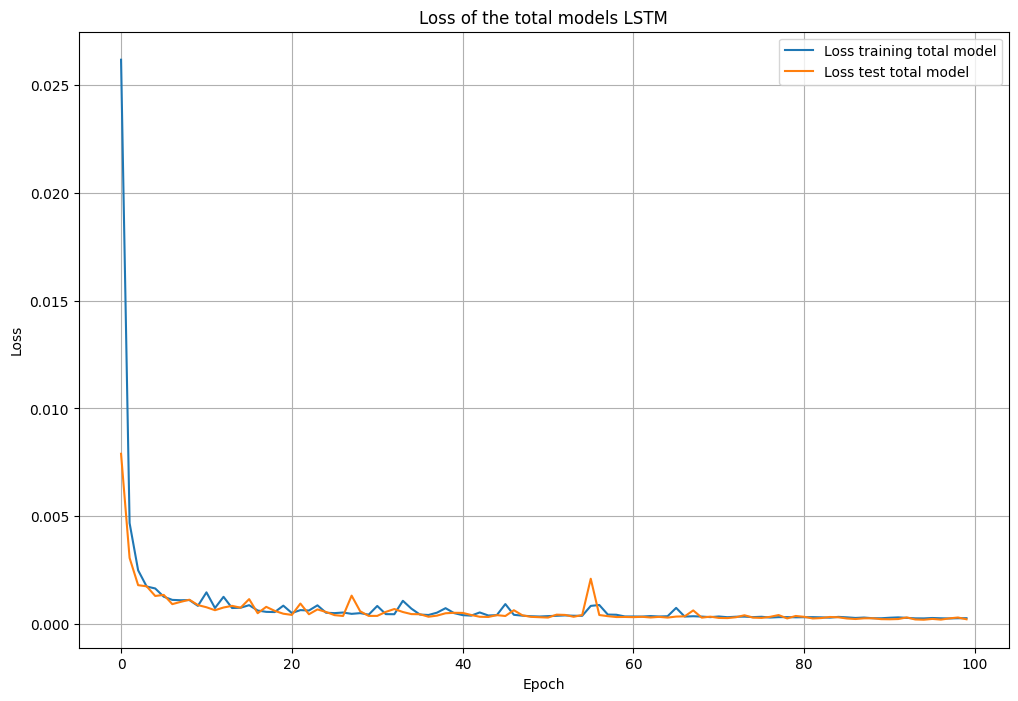

In [ ]:
# plot the loss

plt.figure(figsize=(12, 8))


# loss for the total model

plt.title('Loss of the total models LSTM')
plt.plot(total_history.history['loss'], label='Loss training total model')
plt.plot(total_history.history['val_loss'], label='Loss test total model')


#loss of the 4 models
'''
plt.title('Loss of the four models LSTM')
plt.plot(north_history.history['loss'], label='Loss training north set')
plt.plot(north_history.history['val_loss'], label='Loss test north set')
plt.plot(south_history.history['loss'], label='Loss training south set')
plt.plot(south_history.history['val_loss'], label='Loss test south set')
plt.plot(east_history.history['loss'], label='Loss training east set')
plt.plot(east_history.history['val_loss'], label='Loss test east set')
plt.plot(west_history.history['loss'], label='Loss training west set')
plt.plot(west_history.history['val_loss'], label='Loss test west set')
'''
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# get mean abs error on the original size data

def get_mae(model, input_scaled, output_scaled):
  X_train, X_test, y_train, y_test = train_test_split(input_scaled, output_scaled, test_size=0.2, random_state=42)

  # take back the data to original size
  y_test = descale(y_test, W, H)

  y_pred_scaled = model.predict(X_test) # this are scaled results
  y_pred = descale(y_pred_scaled, W, H) # these are the useful original size results

  return np.mean(np.abs(y_pred - y_test))



In [ ]:
# get mean abs error on the original size data
print(get_mae(total_model, input_scaled, output_scaled))

'''
nm = get_mae(north_model, north_input_scaled, north_output_scaled)
sm = get_mae(south_model, south_input_scaled, south_output_scaled)
em = get_mae(east_model, east_input_scaled, east_output_scaled)
wm = get_mae(west_model, west_input_scaled, west_output_scaled)
print('MAE north:', nm )
print('MAE south:', sm)
print('MAE east:', em)
print('MAE west:', wm)
print('AVG:', (nm+sm+em+wm)/4)
'''

600/600 [==============================] - 4s 4ms/step
9.351646894254072


"\nnm = get_mae(north_model, north_input_scaled, north_output_scaled)\nsm = get_mae(south_model, south_input_scaled, south_output_scaled)\nem = get_mae(east_model, east_input_scaled, east_output_scaled)\nwm = get_mae(west_model, west_input_scaled, west_output_scaled)\nprint('MAE north:', nm )\nprint('MAE south:', sm)\nprint('MAE east:', em)\nprint('MAE west:', wm)\nprint('AVG:', (nm+sm+em+wm)/4)\n"

In [ ]:
# save the model
import os

def save_my_model(base_name, model):
    if os.path.exists('models/' + base_name + ".keras"):
        i = 1
        while os.path.exists(base_name + "_" + str(i) + ".keras"):
            i += 1
        model_name = base_name + "_" + str(i) + ".keras"
    else:
        model_name = base_name + ".keras"

    model.save('models/' + model_name)

    print("Modello salvato con il nome:", model_name)


save_my_model('total_model_V5_100_iter', total_model)
'''
save_my_model('north_model_V6_100_iter', north_model)
save_my_model('south_model_V6_100_iter', south_model)
save_my_model('east_model_V6_100_iter', east_model)
save_my_model('west_model_V6_100_iter', west_model)
'''

Modello salvato con il nome: total_model_V5_100_iter.keras


"\nsave_my_model('north_model_V6_100_iter', north_model)\nsave_my_model('south_model_V6_100_iter', south_model)\nsave_my_model('east_model_V6_100_iter', east_model)\nsave_my_model('west_model_V6_100_iter', west_model)\n"

# Info about the models

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
from keras.models import load_model

def print_model(model):
  model.summary()
  total_params = model.count_params()
  total_memory_bytes = total_params * 4
  total_memory_mb = total_memory_bytes / (1024 ** 2)
  print(f"The model has {total_params} parameters, it weights {total_memory_mb:.2f} MB.")



total_model = load_model('models/total_model_V5_100_iter.keras') # load a model
north_lstm = load_model('models/north_model_V6_100_iter.keras') # load a model

print_model(total_model)
print('\n'*4)
print_model(north_lstm)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                17152     
                                                                 
 repeat_vector_1 (RepeatVec  (None, 50, 64)            0         
 tor)                                                            
                                                                 
 lstm_4 (LSTM)               (None, 50, 32)            12416     
                                                                 
 lstm_5 (LSTM)               (None, 50, 16)            3136      
                                                                 
 time_distributed_1 (TimeDi  (None, 50, 2)             34        
 stributed)                                                      
                                                                 
Total params: 32738 (127.88 KB)
Trainable params: 3273

# Test on YOLO

The callback will make a video with the predictions of the single network or the four different specialized networks.
The predictions are performed only on moving cars.

The script is designed to draw the car's predicted trajectory only while the car remains within its starting zone. This is necessary because our LSTM models were trained on a dataset with a fixed number of output points. Consequently, the model wasn't trained on data representing the car's path near the intersection's exit. As a result, the predictions become inaccurate as the car gets closer to leaving the intersection. By restricting predictions to the starting zone, we ensure they remain reliable and within the scope of the model's training data.



In [ ]:

# install for using yolo and supervision

!pip install supervision
import supervision as sv
!pip install ultralytics
import ultralytics
import numpy as np
from ultralytics import YOLO
from keras.models import load_model
import time
from collections import defaultdict
import numpy as np
from scipy.interpolate import splprep, splev
from shapely.geometry import Point, Polygon
import cv2




In [13]:
# load models
total_model = load_model('models/total_model_V5_100_iter.keras') # load a model
north_lstm = load_model('models/north_model_V6_100_iter.keras') # load a model
south_lstm = load_model('models/south_model_V6_100_iter.keras') # load a model
east_lstm = load_model('models/east_model_V6_100_iter.keras') # load a model
west_lstm = load_model('models/west_model_V6_100_iter.keras') # load a model

model = YOLO('yolov8x.pt')
model.fuse

CLASS_NAMES_DICT = model.model.names
selected_classes = [2,3,5,7] # cars, bus, motorcycle, truck

# video path
file_name = 'incrocio_test' # video to process
SOURCE_VIDEO_PATH = 'videos/' + file_name + '.mp4'
SAVE_PATH_TOTAL_MODEL = 'videos/processed/' + file_name +'_total_model_prediction_all_frames.mp4' # where to save processed video
SAVE_PATH_FOUR_MODELS = 'videos/processed/' + file_name +'_four_models_prediction_all_frames.mp4' # where to save processed video
info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
print(info)

W, H = info.width, info.height

seconds = info.total_frames/info.fps



VideoInfo(width=1280, height=506, fps=30, total_frames=1774)


In [ ]:

from collections import defaultdict
import time

 # associates an id to its entering zone, this is needed because we want to draw
 # the prediction only while the car is not too close to the exit, this is because the model is not trained on the final data
traj_zones = {}

min_interpolation_points = 6 # how many points to use before interpolating the missing points needed for the network
input_size = 10 # input size for the model
frame_multiple = 1 # use only frames that are multiple of frame_multiple to be faster

# supervision annotators
byte_tracker = sv.ByteTrack(frame_rate = info.fps)
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

use_total_model = False

if use_total_model:
  SAVE = SAVE_PATH_TOTAL_MODEL
else:
  SAVE = SAVE_PATH_FOUR_MODELS

object_centers = defaultdict(list) # where to save all coordinates of a certain id
keep = defaultdict(list) # contains last prediction's points to draw

# Define zones, they are needed for two reasons:
# 1: we will draw the prediction only if the car is still in it's starting zone
# 2: if using the four models we will pass the car points to the corresponding model (N S E W)
north_zone = Polygon([Point(300, 300) , Point(700, 250), Point(350, 0), Point(100, 0)])
south_zone = Polygon([Point(600, 300) , Point(900, 250), Point(1800, 700), Point(800, 700)])
west_zone = Polygon([Point(450, 250) , Point(500, 500), Point(0, 500), Point(0, 250)])
east_zone = Polygon([Point(1300, 0) , Point(800, 100), Point(600, 300), Point(1300, 200)])



def get_zone_name(id):
    if not id in traj_zones.keys():
         return 'no-zone'
    zone = traj_zones[id]
    if zone is north_zone:
        return 'north'
    elif zone is south_zone:
        return 'south'
    elif zone is east_zone:
        return 'east'
    elif zone is west_zone:
        return 'west'

def inside_zones(point, zone):
    return zone.contains(Point(point))

# draw the prediction of the lstm on the frame
def draw_predictions(frame, keep, color):
    for id, lines in keep.items():
        for start_point, end_point in lines:
            cv2.line(frame, start_point, end_point, color, 3)
    return frame

# assign each car id to its starting zone
def update_trajectory_zone(first_point, id):
    print(id, first_point, end='--')
    if inside_zones(first_point, north_zone):
        traj_zones[id] = north_zone
    elif inside_zones(first_point, south_zone):
        traj_zones[id] = south_zone
    elif inside_zones(first_point, east_zone):
        traj_zones[id] = east_zone
    elif inside_zones(first_point, west_zone):
        traj_zones[id] = west_zone

# if using the four models we want the prediction of the model specialized on the zone where the car belongs
def get_models_prediction(last_points, id):
    zone = traj_zones[id]
    if zone is north_zone:
        return north_lstm.predict(last_points, verbose=False)
    elif zone is south_zone:
        return south_lstm.predict(last_points, verbose=False)
    elif zone is east_zone:
        return east_lstm.predict(last_points, verbose=False)
    elif zone is west_zone:
        return west_lstm.predict(last_points, verbose=False)
    return -1

# delete predictions if the car is not in the video anymore
def check_to_delete(keep, detections):
  for id in list(keep.keys()):
    if id not in detections.tracker_id:
        del keep[id]

# put the predicted points taht will be used for the trajectory drawing in the keeper
def update_keeper(keep, id, predictions):
  for i in range(1, len(predictions)):
      start_point = (int(predictions[i-1][0] * W), int(predictions[i-1][1] * H)) # denormalize
      end_point = (int(predictions[i][0] * W), int(predictions[i][1] * H))
      keep[id].append((start_point, end_point))

# performs the interpolation, this may be useful to not having to wait too many
# frames before beign able to pass the data to the network
def interpolate(x, y, size):
    tck, u = splprep([x, y], s=0.0)
    new_u = np.linspace(0, 1, size)
    new_x, new_y = splev(new_u, tck)

    for i in range(1, len(new_y)):
        start_point = (int(new_x[i-1]), int(new_y[i-1]))
        end_point = (int(new_x[i]), int(new_y[i]))

    new_x = [x / W for x in new_x] # normalize
    new_y = [y / H for y in new_y]

    return new_x, new_y



def callback(frame: np.ndarray, frame_idx: int) -> np.ndarray:
    if frame_idx % frame_multiple == 0:
        print(frame_idx, '/', info.total_frames)

        results = model(frame, verbose = False)[0]
        detections = sv.Detections.from_ultralytics(results)
        detections = detections[np.isin(detections.class_id, selected_classes)] # class filter
        detections = byte_tracker.update_with_detections(detections)

        if frame_multiple == 1: # draw the labels only if we are processing every frame or the result is eye hurting
          labels = [f"#{tracker_id} - {len(object_centers.copy()[tracker_id])} - {get_zone_name(tracker_id)}" for class_id, tracker_id in zip(detections.class_id, detections.tracker_id)]
          frame = box_annotator.annotate( frame.copy(), detections=detections)
          frame = label_annotator.annotate(frame, detections=detections, labels=labels)

        # delete element if not in the video anymore
        check_to_delete(keep, detections)

        for box, id in zip(detections.xyxy, detections.tracker_id):

            center = (int((box[0] + box[2]) / 2), int((box[1] + box[3]) / 2)) # center of the bounding box
            #scaled_center = np.array([center[0] / W, center[1] / H])

            if not id in object_centers: # first detection
                update_trajectory_zone(center, id)
            object_centers[id].append(np.array(center))


            cv2.circle(frame, (center[0], center[1]), 15, (0, 255, 0), -1)

            if id in traj_zones.keys():
                # we want to predict only if the car has enough points for the interpolation and it has not left the starting zone
                if (len(object_centers[id]) >= min_interpolation_points) and inside_zones(center, traj_zones[id]):
                    elems = np.array(object_centers[id][-min_interpolation_points:]) # last elements
                    x, y = elems[:, 0], elems[:, 1]

                    # check if there are no doubled points, in the other case the car is not moving
                    xy_pairs = set(zip(x, y))
                    if len(xy_pairs) == len(x):
                        new_x, new_y = interpolate(x, y, input_size)
                    else:
                      continue # if car not moving no need to perform prediction again

                    if use_total_model:
                        y_scaled = total_model.predict(np.array([np.column_stack((new_x, new_y))]), verbose=False)
                    else:
                        y_scaled = get_models_prediction(np.array([np.column_stack((new_x, new_y))]), id)

                    y_pred = y_scaled.squeeze()

                    # data to draw interpolated points
                    if id in list(keep.keys()): keep[id] = [] #draw only last pred

                    update_keeper(keep, id, y_pred) # update the keeper id with last trajectory prediction

            frame = draw_predictions(frame, keep, (0, 255, 0)) # draw predictions

        return frame

    return draw_predictions(frame, keep, (0,255,0)) # draw predictions also on other frames


start_time = time.time()
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=SAVE,
    callback=callback
)
end_time = time.time()

difference = end_time - start_time
print(f'\n \nRequired: {difference} seconds, the video is {seconds} long -> difference: {difference-seconds}')
if difference-seconds <= 0:
  print('Real time performance achieved! :)')
else:
  print('Real time performance not achieved! :(')

# This is what the defined zones looks like

True


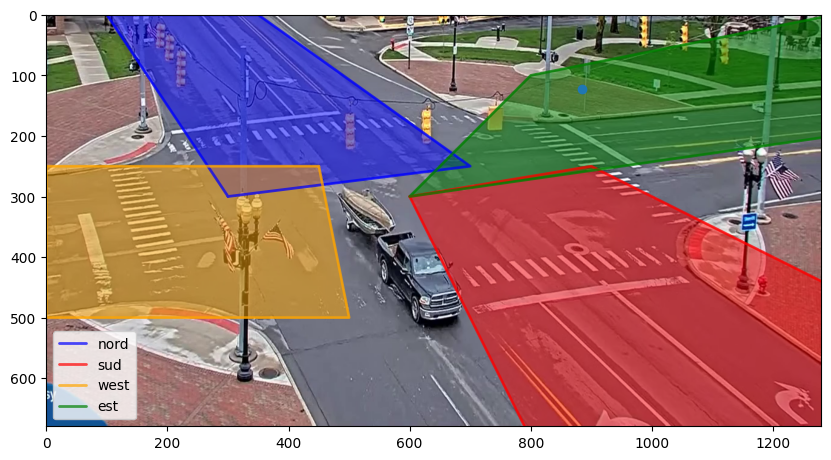

In [56]:
#DEFINIZIONE ZONE N S E W
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import cv2

colors = {'nord': 'blue', 'est': 'green', 'sud':'red', 'west': 'orange'}


def plot_zone(name, zone):
    x_coords, y_coords = zone.exterior.xy

    plt.plot(x_coords, y_coords, alpha=0.7, linewidth=2, solid_capstyle='round', zorder=2, color=colors[name], label = name)
    plt.fill(x_coords, y_coords, alpha=0.5, zorder=1, color=colors[name])



# Definizione dei punti iniziali e finali delle linee che delimitano le regioni
north_zone = Polygon([Point(300, 300) , Point(700, 250), Point(350, 0), Point(100, 0)])
south_zone = Polygon([Point(600, 300) , Point(900, 250), Point(1800, 700), Point(800, 700)])
west_zone = Polygon([Point(450, 250) , Point(500, 500), Point(0, 500), Point(0, 250)])
east_zone = Polygon([Point(1300, 0) , Point(800, 100), Point(600, 300), Point(1300, 200)])

cap = cv2.VideoCapture('videos/incrocio_mod.mp4')
ret, frame = cap.read()
cap.release()

plt.figure(figsize=(10, 8))
plot_zone('nord', north_zone)
plot_zone('sud', south_zone)
plot_zone('west', west_zone)
plot_zone('est', east_zone)
plt.legend()
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

